# Chapter 5 - Connecting Causality and Deep Learning

The notebook is a code companion to chapter 5 of the book [Causal AI](https://www.manning.com/books/causal-ai) by [Robert Osazuwa Ness](https://www.linkedin.com/in/osazuwa/).

<a href="https://colab.research.google.com/github/altdeep/causalML/blob/master/book/chapter%205/chapter_5_Connecting_Causality_and_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook was written in Google Colab using Python version 3.10.12. The versions of the main libraries include:
* pyro version 1.84
* torch version 2.2.1
* pandas version 2.0.3
* torchvision vserions 0.18.0+cu121




Pgmpy allows us to fit conventional Bayesian networks on a causal DAG. However, with modern deep probabilistic machine learning frameworks like pyro, we can build more nuanced and powerful causal models.  In this tutorial, we fit a variational autoencoder on a causal DAG that represents a dataset that mixes handwritten MNIST digits and typed T-MNIST images.

![TMNIST-MNIST](https://github.com/altdeep/causalML/blob/master/book/chapter%205/images/MNIST-TMNIST.png?raw=1)

In [69]:
# !pip install pyro-ppl==1.8.4
# !pip install torchvision

## Listing 5.1: Setup for GPU training

The code will run faster if we use CUDA, if it's available.

In [70]:
import torch    #A
USE_CUDA = True    #A
DEVICE_TYPE = torch.device("cuda" if USE_CUDA else "cpu")    #A
#A Use CUDA if it is available.

## Listing 5.2: Combining the data

First, we create a Dataset object that will combine our two datasets.

In [71]:
from torch.utils.data import Dataset

import numpy as np
import pandas as pd
from torchvision import transforms

class CombinedDataset(Dataset):    #A
    def __init__(self, csv_file):
        self.dataset = pd.read_csv(csv_file)
        print(self.dataset.shape)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        images = self.dataset.iloc[idx, 3:]    #B
        images = np.array(images, dtype='float32')/255.  #B
        images = images.reshape(28, 28)    #B
        transform = transforms.ToTensor()    #B
        images = transform(images)    #B
        digits = self.dataset.iloc[idx, 2]    #C
        digits = np.array([digits], dtype='int')    #C
        is_handwritten = self.dataset.iloc[idx, 1]    #D
        is_handwritten = np.array([is_handwritten], dtype='float32')    #D
        return images, digits, is_handwritten    #E

#A This class loads and processes a dataset that combines the MNIST and Typeface MNIST. The output is a torch.utils.data.Dataset object.
#B Load, normalize, and reshape the images to a 28x28 pixel.
#C Get and process the digits labels, 0-9.
#D 1 for handwritten digits (MNIST) 0 for “typed’ digits (TMNIST).
#E Return tuple of the image, the digit label, and the is_handwritten label.

## Listing 5.3: Downloading, splitting and loading the data

Next, we'll download the data and create the combined dataset.

In [72]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split

def setup_dataloaders(batch_size=64, use_cuda=USE_CUDA):    #A
    combined_dataset = CombinedDataset(
"https://raw.githubusercontent.com/altdeep/causalML/master/datasets/combined_mnist_tmnist_data.csv"
    )
    n = len(combined_dataset)    #B
    train_size = int(0.8 * n)    #B
    test_size = n - train_size    #B
    train_dataset, test_dataset = random_split(    #B
        combined_dataset,    #B
        [train_size, test_size],    #B
        generator=torch.Generator().manual_seed(42)    #B
    )    #B
    kwargs = {'num_workers': 1, 'pin_memory': use_cuda}
    train_loader = DataLoader(    #C
        train_dataset,    #C
        batch_size=batch_size,    #C
        shuffle=True,    #C
        **kwargs    #C
    )    #C
    test_loader = DataLoader(    #C
        test_dataset,    #C
        batch_size=batch_size,    #C
        shuffle=True,    #C
        **kwargs    #C
    )    #C
    return train_loader, test_loader
#A Setup data loader that loads the data and splits it into training and test sets
#B Allot 80% of the data to training data, the remaining 20% to test data.
#C Create training and test loaders.

In [73]:
train_loader, test_loader = setup_dataloaders()

(50000, 787)


column 0 is simply index of the datapoint in the dataset, column 1 is is_handwritten, column 2 is digits, columns 3: are image values

## Listing 5.4: Implement the decoder

First, we specify a decoder. The decoder maps the latent variable Z, a variable representing the value of the digit, and a binary variable representing whether the digit is handwritten.

In [74]:
from torch import nn

# This is the diffusion reverse model that predicts the conditional mean of the noise epsilon_t at any time step t given the noisy image x_t and the causal conditioning variables.
# The output is a vector of size img_dim with real values that directly denote the predicted noise that was added during the forward process - not a distribution.

class Decoder(nn.Module):
    def __init__(self, hidden_dim, T):
        super().__init__()
        img_dim = 28 * 28
        digit_dim = 10
        is_handwritten_dim = 1
        t_dim = 1
        self.T = T

        self.softplus = nn.Softplus()

        encoding_dim = img_dim + digit_dim + is_handwritten_dim + t_dim
        self.fc1 = nn.Linear(encoding_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, img_dim)

    def forward(self, x_t, digit, is_handwritten, t):
        x_t = x_t.view(x_t.size(0), -1)
        t_norm = (t.unsqueeze(1).float() / self.T)
        input = torch.cat([x_t, digit, is_handwritten, t_norm], dim=1)
        h1 = self.softplus(self.fc1(input))
        h2 = self.softplus(self.fc2(h1))
        eps_hat = self.fc3(h2)
        return eps_hat

In [75]:
import pyro
import pyro.distributions as dist

In [83]:
class Diffusion(nn.Module):
    def __init__(self, T=1000, hidden_dim=400, use_cuda=USE_CUDA):
        super().__init__()
        self.use_cuda = use_cuda
        self.T = T
        self.hidden_dim = hidden_dim
        
        # 1. Setup the reverse-process network
        self.decoder = Decoder(hidden_dim, T=T)
        
        # 2. Setup fixed diffusion schedule
        self.setup_schedule()
        
        if self.use_cuda:
            self.cuda()

    def setup_schedule(self):
        """Precompute alpha-bars. Using register_buffer ensures these 
        move to the GPU automatically with the model."""
        betas = torch.linspace(1e-4, 0.02, self.T)
        alphas = 1.0 - betas
        # Registering as buffer handles device placement during .cuda() calls
        self.register_buffer('alpha_bars', torch.cumprod(alphas, dim=0))
        self.register_buffer('betas', betas)
        self.register_buffer('alphas', alphas)

    def q_sample(self, x0, t, eps):
        """The forward process: x0 -> xt. Anchor all constants to x0.device."""
        # Ensure t is an index tensor on the same device as alpha_bars
        t = t.to(self.alpha_bars.device)
        
        # Extract coefficients and ensure they are on the correct device
        sqrt_ab = self.alpha_bars[t].sqrt().unsqueeze(1).to(x0.device)
        sqrt_1_ab = (1 - self.alpha_bars[t]).sqrt().unsqueeze(1).to(x0.device)
        
        return sqrt_ab * x0 + sqrt_1_ab * eps

    def model(self, x0, data_size=1):
        pyro.module("decoder", self.decoder)
        device = x0.device # This is our 'anchor' device
        options = dict(dtype=torch.float32, device=device)
        
        # 1. Sample diffusion time (Batched)
        # Probabilities must be on the same device as the data
        batched_probs = torch.ones(data_size, self.T, **options) / self.T
        t = pyro.sample("t", dist.Categorical(batched_probs))

        # 2. Sample exogenous noise (The latent 'style' equivalent)
        # Using zeros_like(x0) guarantees eps is on x0's device
        eps = pyro.sample("eps", dist.Normal(torch.zeros_like(x0), 1.0).to_event(1))
        
        # 3. Sample Causal Parents
        p_digit = torch.ones(data_size, 10, **options) / 10
        digit = pyro.sample("digit", dist.OneHotCategorical(p_digit))

        p_is_hw = torch.ones(data_size, 1, **options) / 2
        is_handwritten = pyro.sample("is_handwritten", dist.Bernoulli(p_is_hw).to_event(1))

        # 4. Forward diffusion
        x_t = self.q_sample(x0, t, eps)

        # 5. Predict noise (The Decoder handles its own device internally via pyro.module)
        eps_hat = self.decoder(x_t, digit, is_handwritten, t)

        # 6. Observation
        pyro.sample("obs_eps", dist.Normal(eps_hat, 0.1).to_event(1), obs=eps)

        return x_t, eps, digit, is_handwritten

    def training_model(self, img, digit, is_handwritten, batch_size):
        # Conditioning inherits the device of the tensors passed in
        conditioned_on_data = pyro.condition(
            self.model,
            data={"digit": digit, "is_handwritten": is_handwritten}
        )
        with pyro.plate("data", batch_size):
            return conditioned_on_data(x0=img, data_size=batch_size)

    def training_guide(self, img, digit, is_handwritten, batch_size):
        """The guide must mirror the model's device placement."""
        device = img.device
        with pyro.plate("data", batch_size):
            # Anchor probabilities to the image device
            batched_probs = torch.ones(batch_size, self.T, device=device) / self.T
            pyro.sample("t", dist.Categorical(batched_probs))
            
            # Anchor noise to the image device
            pyro.sample("eps", dist.Normal(torch.zeros_like(img), 1.0).to_event(1))

## Listing 5.10 Helper function for plotting images

The following utility functions helps us visualize progress during training.

In [84]:
def plot_image(img, title=None):    #A
    fig = plt.figure()
    img_to_show = (img.cpu().detach() + 1.0) / 2.0
    plt.imshow(img_to_show, cmap='Greys_r', interpolation='nearest')
    if title is not None:
        plt.title(title)
    plt.show()
#A Helper function for plotting an image

## Listing 5.11: Define a helper functions for reconstructing and viewing the images

These additional utility functions help us selected and reshape images, as well as generate new images.

In [85]:
import matplotlib.pyplot as plt

In [86]:
import torch.nn.functional as F

def reconstruct_img(diffusion, img, digit, is_hw, t_val=500, use_cuda=USE_CUDA):
    device = torch.device("cuda" if use_cuda else "cpu")
    
    # 1. Prepare Inputs - Ensure all are (1, Features)
    img = img.reshape(1, -1).to(device) 
    
    # Create digit tensor correctly
    digit_tensor = torch.zeros(1, 10, device=device)
    digit_tensor[0, digit] = 1.0
    
    # Create is_hw tensor as (1, 1)
    is_hw_tensor = torch.tensor([[float(is_hw)]], device=device)
    
    # Create t_tensor as (1,)
    t_tensor = torch.tensor([t_val], device=device)

    # 2. Add Noise
    eps = torch.randn_like(img)
    x_t = diffusion.q_sample(img, t_tensor, eps)

    # 3. Predict the Noise
    eps_hat = diffusion.decoder(x_t, digit_tensor, is_hw_tensor, t_tensor)

    # 4. Mathematical Reconstruction
    # Anchor alpha_bars to the correct device
    alpha_bar_t = diffusion.alpha_bars[t_tensor].to(device)
    sqrt_alpha_bar = alpha_bar_t.sqrt().unsqueeze(1)
    sqrt_one_minus_alpha_bar = (1 - alpha_bar_t).sqrt().unsqueeze(1)
    
    img_reconstructed = (x_t - sqrt_one_minus_alpha_bar * eps_hat) / sqrt_alpha_bar

    return img_reconstructed.view(28, 28).detach()

def compare_images(original, reconstruction):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    images = [original, reconstruction]
    titles = ['Original', 'Reconstructed']
    
    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img.cpu(), cmap='Greys_r', interpolation='nearest')
        ax.set_title(title)
        ax.axis('off')
        
    plt.show()

## Listing 5.12: Data processing helper functions for training

Next, we'll create some helper functions for handling the data. We'll use `get_random_example` to grab random images from the dataset. `reshape_data` will convert an image and its labels into input for the encoder. We'll use `generate_data` and `generate_coded_data` will simulate an image from the model.

In [87]:
import torch.nn.functional as F

def get_random_example(loader):    #A
    random_idx = np.random.randint(0, len(loader.dataset))    #A
    img, digit, is_handwritten = loader.dataset[random_idx]    #A
    return img.squeeze(), digit, is_handwritten    #A

def reshape_data(img, digit, is_handwritten):    #B
    digit = F.one_hot(digit, 10).squeeze()    #B
    img = (img.reshape(-1, 28*28) * 2.0) - 1.0    #B
    return img, digit, is_handwritten    #B

@torch.no_grad()
def p_sample(diffusion, x_t, t, digit, is_hw):
    """
    Reverse diffusion step: samples x_{t-1} given x_t.
    """
    # 1. Predict the noise using the decoder
    eps_hat = diffusion.decoder(x_t, digit, is_hw, t)

    # 2. Calculate coefficients for the reverse step
    # Based on the DDPM math: x_{t-1} = 1/sqrt(alpha) * (x_t - beta/sqrt(1-ab) * eps_hat)
    beta_t = diffusion.betas[t]
    sqrt_one_minus_alpha_bar_t = (1 - diffusion.alpha_bars[t]).sqrt()
    sqrt_alpha_t = diffusion.alphas[t].sqrt()

    # The predicted mean of x_{t-1}
    mean = (1 / sqrt_alpha_t) * (x_t - (beta_t / sqrt_one_minus_alpha_bar_t) * eps_hat)

    if t == 0:
        return mean
    else:
        # Add a bit of 'fresh' noise (Langevin dynamics) to keep generation diverse
        noise = torch.randn_like(x_t)
        sigma_t = beta_t.sqrt() # Standard DDPM variance choice
        return mean + sigma_t * noise
    
def generate_coded_data(diffusion, use_cuda=USE_CUDA):
    device = torch.device("cuda" if use_cuda else "cpu")
    
    # 1. Start with Pure Noise (The Diffusion 'Latent')
    img_shape = (1, 28 * 28)
    x = torch.randn(img_shape, device=device)

    # 2. Sample Causal Parents (Digit and Style)
    p_digit = torch.ones(1, 10, device=device) / 10
    digit = dist.OneHotCategorical(p_digit).sample()
    
    p_is_hw = torch.ones(1, 1, device=device) / 2
    is_handwritten = dist.Bernoulli(p_is_hw).sample()

    # 3. The Reverse Loop (The 'Generation' work)
    # We step from t=999 all the way down to t=0
    for t_idx in reversed(range(diffusion.T)):
        t_tensor = torch.tensor([t_idx], device=device)
        x = p_sample(diffusion, x, t_tensor, digit, is_handwritten)

    return x, digit, is_handwritten

def generate_data(diffusion, use_cuda=USE_CUDA):
    # This remains the wrapper that cleans up shapes for plotting
    img, digit, is_handwritten = generate_coded_data(diffusion, use_cuda)
    
    img = img.squeeze().view(28, 28).detach()
    digit = torch.argmax(digit, 1)
    # is_handwritten for Bernoulli is usually just the value
    is_handwritten = is_handwritten.squeeze().round().int() 
    
    return img, digit, is_handwritten

## Listing 5.13: Set up the training procedure

Next we set up traing. The training objective `Trace_ELBO` simultaneously trains the parameters of the encoder and the decoder. It focuses on minimizing reconstruction error (how much information is lost when an image encoded, and then decoded once again) and [KL-divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) between the distribution modeled by the guide (the variational distribution) and the P(Z|image, is_handwritten, digit).

In [88]:
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

# 1. Clear previous parameters
pyro.clear_param_store()

# 2. Initialize the Diffusion Class
T_steps = 2000
diffusion_model = Diffusion(T=T_steps, hidden_dim=400)
train_loader, test_loader = setup_dataloaders(batch_size=256)

# 3. Setup Optimizer
# We use a slightly lower learning rate often preferred for Diffusion
optimizer = Adam({"lr": 1.0e-3})

# 4. Define Model and Guide
# We point SVI to the 'training' versions we wrote
model = diffusion_model.training_model
guide = diffusion_model.training_guide

# 5. Initialize SVI
# Trace_ELBO works here because our 'model' has an 'obs=' statement 
# and our 'guide' samples the same latent variables (t, eps).
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

(50000, 787)


## Listing 5.14: Setting up a test evaluation procedure

When training generative models, it is useful to setup a procedure that uses test data to evaluate how well training is progressing. You can include anything you think is useful to monitor during training. Here, I calculate and print the loss function on the test data, just to make sure test loss is progressively decreasing along with training loss (a flattening of test loss while training loss continued to decrease would indicate overfitting).

But a more direct signal at how well our model is training is to generate and view images. In my test evaluation procedure, I produce two visualizations. First, I inspect how well it can reconstruct a random image from the test data. I pass the image through the encoder then through the decoder, creating a “reconstruction” of the image. Then I plot the original and reconstructed image side-by-side and compare them visually, looking to see that they are close to identical.

Next, I visualize how well it is performing as an overall generative model by generating and plotting an image from scratch. I run this code once each time a certain number of epochs are run.

In [89]:
def test_epoch(diffusion, test_loader, epoch):
    epoch_loss_test = 0
    
    # 1. Calculate Test Loss (Quantitative Check)
    for img, digit, is_hw in test_loader:
        batch_size = img.shape[0]
        if USE_CUDA:
            img, digit, is_hw = img.cuda(), digit.cuda(), is_hw.cuda()
            
        img, digit, is_hw = reshape_data(img, digit, is_hw)
        
        # evaluate_loss does everything step() does but WITHOUT updating weights
        epoch_loss_test += svi.evaluate_loss(img, digit, is_hw, batch_size)
        
    test_size = len(test_loader.dataset)
    avg_loss = epoch_loss_test / test_size
    print(f"Epoch: {epoch} avg. test loss: {avg_loss:.4f}")

    # 2. Visualize Reconstruction (Qualitative Check: Denoising)
    print("Comparing a random test image to its (one-step) reconstruction:")
    img_r, digit_r, is_hw_r = get_random_example(test_loader)
    
    # We use a mid-range t (e.g., 400) to see if it can recover from significant noise
    t_test = 1000 
    img_recon = reconstruct_img(diffusion, img_r, digit_r, is_hw_r, t_val=t_test)
    
    # You might want to modify compare_images to show the original vs reconstruction
    compare_images(img_r.view(28, 28), img_recon)

    # 3. Generate New Image (Qualitative Check: Full Reverse Process)
    print("Generate a brand new image by sampling from pure noise:")
    # This calls your generate_data function with the 1000-step loop
    img_gen, digit_gen, is_hw_gen = generate_data(diffusion)
    
    plot_image(img_gen, f"Generated: Digit {int(digit_gen)}")
    print(f"Intended digit: {int(digit_gen)}")
    print(f"Intended as handwritten: {bool(is_hw_gen == 1)}")

## Listing 5.15: Running training and plotting progress

Finally, we run training.

Epoch: 0 | Avg Training Loss (ELBO): 36720.1081
Epoch: 0 avg. test loss: 33039.8049
Comparing a random test image to its (one-step) reconstruction:


/local/scratch/a/jshreeku/tmp/ipykernel_3012038/2670287072.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  is_hw_tensor = torch.tensor([[float(is_hw)]], device=device)


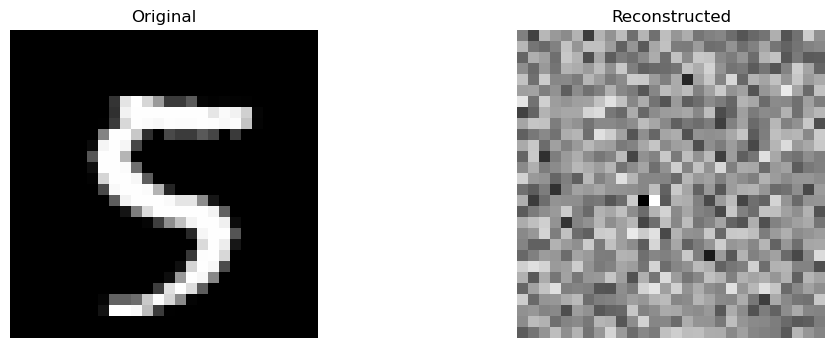

Generate a brand new image by sampling from pure noise:


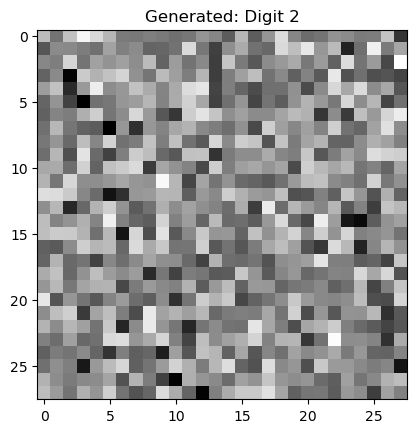

Intended digit: 2
Intended as handwritten: False
Epoch: 1 | Avg Training Loss (ELBO): 29665.8902
Epoch: 2 | Avg Training Loss (ELBO): 26527.1746


KeyboardInterrupt: 

In [90]:
NUM_EPOCHS = 2500
TEST_FREQUENCY = 100  # Note: Generation is slow, so you might increase this later

train_loss = []
train_size = len(train_loader.dataset)

for epoch in range(0, NUM_EPOCHS + 1):
    loss = 0
    for img, digit, is_handwritten in train_loader:
        batch_size = img.shape[0]
        
        if USE_CUDA:
            img = img.cuda()
            digit = digit.cuda()
            is_handwritten = is_handwritten.cuda()
            
        # Re-use your existing reshape_data function
        img, digit, is_handwritten = reshape_data(img, digit, is_handwritten)
        
        # SVI.step logic:
        # This calls: training_model(img, digit, is_handwritten, batch_size)
        # And: training_guide(img, digit, is_handwritten, batch_size)
        loss += svi.step(img, digit, is_handwritten, batch_size)
        
    avg_loss = loss / train_size
    train_loss.append(avg_loss)
    
    print(f"Epoch: {epoch} | Avg Training Loss (ELBO): {avg_loss:.4f}")

    # Run the qualitative and quantitative test procedure
    if epoch % TEST_FREQUENCY == 0:
        # Note: We pass 'diffusion_model' (your class instance) instead of 'vae'
        test_epoch(diffusion_model, test_loader, epoch)

We can continue to use `generate_data` to generate from the model once we've trained it. Finally, we can save the resulting model.

In [ ]:
#torch.save(vae.state_dict(), 'mnist_tmnist_weights.pt')

In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pyro
import pyro.distributions as dist
import numpy as np
import matplotlib.pyplot as plt
from pyro.optim import Adam

In [57]:
class Decoder(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(784 + 10 + 1 + 1, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 784)
        self.softplus = nn.Softplus()

    def forward(self, x_t, digit, is_hw, t):
        x_t = x_t.view(x_t.size(0), -1)

        digit = digit.view(digit.size(0), -1)   # 🔧 force 2D
        is_hw = is_hw.view(is_hw.size(0), -1)   # 🔧 force 2D
        t = t.view(t.size(0), 1).float()         # 🔧 force 2D

        h = torch.cat([x_t, digit, is_hw, t], dim=1)
        h = self.softplus(self.fc1(h))
        return self.fc2(h)

In [58]:
class Diffusion(nn.Module):
    def __init__(self, T=1000, hidden_dim=400):
        super().__init__()
        self.T = T
        self.decoder = Decoder(hidden_dim)
        self.setup_schedule()

    def setup_schedule(self):
        betas = torch.linspace(1e-4, 0.02, self.T)
        alphas = 1.0 - betas
        self.register_buffer("betas", betas)
        self.register_buffer("alphas", alphas)
        self.register_buffer("alpha_bars", torch.cumprod(alphas, dim=0))

    def q_sample(self, x0, t, eps):
        sqrt_ab = self.alpha_bars[t].sqrt().unsqueeze(1)
        sqrt_1_ab = (1 - self.alpha_bars[t]).sqrt().unsqueeze(1)
        return sqrt_ab * x0 + sqrt_1_ab * eps

    # ✅ THIS MUST BE INSIDE THE CLASS
    def model(self, x0, digit, is_hw):
        pyro.module("decoder", self.decoder)

        batch_size = x0.size(0)
        device = x0.device

        t = pyro.sample(
            "t",
            dist.Categorical(torch.ones(batch_size, self.T, device=device) / self.T)
        )

        eps = pyro.sample(
            "eps",
            dist.Normal(torch.zeros_like(x0), 1.0).to_event(1)
        )

        x_t = self.q_sample(x0, t, eps)
        eps_hat = self.decoder(x_t, digit, is_hw, t)

        mse = ((eps - eps_hat) ** 2).sum(dim=1)
        pyro.factor("diffusion_loss", -mse.mean())

In [59]:
@torch.no_grad()
def p_sample(diffusion, x_t, t, digit, is_hw):
    eps_hat = diffusion.decoder(x_t, digit, is_hw, t)

    beta = diffusion.betas[t]
    alpha = diffusion.alphas[t]
    alpha_bar = diffusion.alpha_bars[t]

    mean = (1 / alpha.sqrt()) * (
        x_t - (beta / (1 - alpha_bar).sqrt()) * eps_hat
    )

    if t.item() == 0:
        return mean

    noise = torch.randn_like(x_t)
    return mean + beta.sqrt() * noise

In [60]:
@torch.no_grad()
def generate(diffusion):
    device = next(diffusion.parameters()).device
    x = torch.randn(1, 28*28, device=device)

    digit = F.one_hot(torch.randint(0, 10, (1,)), 10).float().to(device)
    is_hw = torch.bernoulli(torch.ones(1,1, device=device) * 0.5)

    for t in reversed(range(diffusion.T)):
        x = p_sample(diffusion, x, torch.tensor([t], device=device), digit, is_hw)

    return x.view(28,28), digit.argmax(), is_hw.item()

In [66]:
from pyro import poutine

def train(diffusion, train_loader, epochs=1000, lr=1e-3):
    optimizer = torch.optim.Adam(diffusion.parameters(), lr=lr)

    for epoch in range(epochs):
        total_loss = 0.0

        for img, digit, is_hw in train_loader:
            img = img.view(img.size(0), -1)
            digit = F.one_hot(digit.view(-1), 10).float()
            is_hw = is_hw.view(-1, 1).float()

            optimizer.zero_grad()

            # 1️⃣ Sample t and eps for diffusion
            batch_size = img.size(0)
            t = torch.randint(0, diffusion.T, (batch_size,), device=img.device)
            eps = torch.randn_like(img)

            # 2️⃣ Forward diffusion
            x_t = diffusion.q_sample(img, t, eps)

            # 3️⃣ Predict noise
            eps_hat = diffusion.decoder(x_t, digit, is_hw, t)

            # 4️⃣ MSE loss
            loss = ((eps - eps_hat) ** 2).mean()

            # 5️⃣ Backprop
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch} | Avg Loss: {total_loss / len(train_loader):.4f}")

In [67]:

train_loader, test_loader = setup_dataloaders(batch_size=256)

# 3. Setup Optimizer
# We use a slightly lower learning rate often preferred for Diffusion
optimizer = Adam({"lr": 1.0e-3})


T_steps = 2000
diffusion_model = Diffusion(T=T_steps, hidden_dim=400)


train(diffusion=diffusion_model, train_loader=train_loader)

(50000, 787)
Epoch 0 | Avg Loss: 2.2540
Epoch 1 | Avg Loss: 0.8087
Epoch 2 | Avg Loss: 0.7017
Epoch 3 | Avg Loss: 0.6591
Epoch 4 | Avg Loss: 0.6382
Epoch 5 | Avg Loss: 0.6222
Epoch 6 | Avg Loss: 0.6133
Epoch 7 | Avg Loss: 0.6103
Epoch 8 | Avg Loss: 0.6046
Epoch 9 | Avg Loss: 0.5988
Epoch 10 | Avg Loss: 0.5931
Epoch 11 | Avg Loss: 0.5860
Epoch 12 | Avg Loss: 0.5773
Epoch 13 | Avg Loss: 0.5731
Epoch 14 | Avg Loss: 0.5676
Epoch 15 | Avg Loss: 0.5623
Epoch 16 | Avg Loss: 0.5580
Epoch 17 | Avg Loss: 0.5567
Epoch 18 | Avg Loss: 0.5546
Epoch 19 | Avg Loss: 0.5524
Epoch 20 | Avg Loss: 0.5508
Epoch 21 | Avg Loss: 0.5506
Epoch 22 | Avg Loss: 0.5488
Epoch 23 | Avg Loss: 0.5498
Epoch 24 | Avg Loss: 0.5493
Epoch 25 | Avg Loss: 0.5495
Epoch 26 | Avg Loss: 0.5492
Epoch 27 | Avg Loss: 0.5487
Epoch 28 | Avg Loss: 0.5501
Epoch 29 | Avg Loss: 0.5498
Epoch 30 | Avg Loss: 0.5485
Epoch 31 | Avg Loss: 0.5491
Epoch 32 | Avg Loss: 0.5491
Epoch 33 | Avg Loss: 0.5481
Epoch 34 | Avg Loss: 0.5501
Epoch 35 | Avg Lo

KeyboardInterrupt: 

In [65]:
img, digit, is_hw = next(iter(train_loader))
img = img.view(img.size(0), -1)
digit = F.one_hot(digit.view(-1), 10).float()
is_hw = is_hw.view(-1, 1).float()

trace = poutine.trace(diffusion_model.model).get_trace(img, digit, is_hw)
print(trace.nodes.keys())
print(trace.nodes["diffusion_loss"]["value"].shape)

odict_keys(['_INPUT', 'decoder$$$fc1.weight', 'decoder$$$fc1.bias', 'decoder$$$fc2.weight', 'decoder$$$fc2.bias', 't', 'eps', 'diffusion_loss', '_RETURN'])
torch.Size([0])
